In [12]:
import networkx as nx
import numpy as np
import scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
%matplotlib notebook
import csv
import os
import itertools

import random
from collections import defaultdict
from operator import itemgetter
import math 

import pickle


In [2]:
from scripts.utility import *
from scripts.features import *

# Features
It is a good idea to save our features in text files, so that we only have to calculate them once. Later on when we employ clustering, we can just read the values off of these files instead of iterating over the graphs again, which is time consuming.

## 1. Geometrical

### 1.1 Number of nodes and edges

In [ ]:
# Calculate the number of nodes and edges for each network and save them to files
with open('features/n_nodes.txt', 'w') as node_file, open('features/n_edges.txt', 'w') as edge_file:
    for network_id, G in graph_generator():
        node_file.write(network_id + '\t' + str(nx.number_of_nodes(G)) + '\n') # nx.number_of_nodes() function
        edge_file.write(network_id + '\t' + str(nx.number_of_edges(G)) + '\n') # use tab character \t, not two spaces
        
###NOTE: Have to pull features from github before running script
##IDEA: Can calculate every feature on the same loop

### 1.2 Average node degree

In [ ]:
# Calculate the average node degree, i.e. the average number of edges that are connected to a node,
# for each network and write them to a file
with open('features/average_node_degree.txt', 'w') as file:
    for network_id, G in graph_generator(): 
        average_node_degree = np.mean(list(G.degree().values()))
        file.write(network_id + '\t' + str(average_node_degree) + '\n')

### 1.3 Vein density

Vein density **$\sigma$** is calculated by summing the total length of all veins and dividing by total leaf area.


In [ ]:
save_feature(vein_density, skip_existing=True, clean=False)

### 1.4 Areole area

Areole area **$A$** is obtained calculating basic cycle areas using the standard formula for the area of a general polygon.

In [ ]:
save_feature(areole_area, skip_existing=True, clean=False)

### 1.5 Areole density 

Areole density **$\rho_A$** is the total number of areoles divided by leaf area.

In [ ]:
save_feature(areole_density, skip_existing=True, clean=False)

### 1.6 Weighted vein thickness

Weighted vein thickness **$d$** is calculated as the total sum of the product radius*length of each
    individual vein segment divided by total vein length

In [ ]:
save_feature(weighted_vein_thickness, skip_existing=True, clean=False)

## 2. Topological

### 2.1 Nesting number

In [ ]:
save_feature(nesting_numbers, skip_existing=True, clean=True)

# Data Analysis

In [ ]:
data = read_features()

In [ ]:
feature_names = [
    'topological_length',  
    'nesting_number_weighted_no_ext',
    #'nesting_number_unweighted',
    #'nesting_number_weighted',
    'nesting_number_unweighted_no_ext',
    'vein_density',
    'vein_distance',
    'areole_area',
    'areole_density',
    'weighted_vein_thickness',
    #'average_node_degree',
    #'n_edges',
    #'n_nodes',
    
]

feature_labels = {
    'topological_length'              : r'$L_{top}$',
    'nesting_number_weighted'         : r'$i_w$',
    'nesting_number_weighted_no_ext'  : r'$i_w^{no}$',
    'nesting_number_unweighted'       : r'$i_u$',
    'nesting_number_unweighted_no_ext': r'$i_u^{no}$',
    'vein_density'                    : r'$\sigma$',
    'vein_distance'                   : r'$a$',
    'areole_area'                     : r'$A$',
    'areole_density'                  : r'$\rho_A$',
    'weighted_vein_thickness'         : r'$d$',
    'average_node_degree'             : r'$deg_N$',
    'n_edges'                         : r'$N_e$',
    'n_nodes'                         : r'$N_n$',
}

In [ ]:
network_ids = sorted(data['nesting_number_weighted'].keys())
#print(network_ids)

## Principal Component Analysis

In [ ]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids]
    X.append(row)
X = np.array(X)
X = X.T
X = X - np.mean(X, axis=0)
X1 = X / np.std(X, axis=0)
X2 = X / np.max(X, axis=0)

In [ ]:
for X in [X1, X2]:
    pca = PCA()
    pca.fit(X)
    
    normalized_eigenvalues = pca.explained_variance_ratio_
    #print(normalized_eigenvalues)
    
    principal_components = pca.components_
    #print(principal_components)
    
    scaled_principal_components = (normalized_eigenvalues * principal_components.T).T
    #print(scaled_principal_components)
    
    relative_feature_contributions = np.sum(abs(scaled_principal_components), axis=0)
    #print(relative_feature_contributions)
    
    
    fig, ax = plt.subplots()
    x = np.arange(len(relative_feature_contributions))
    ax.bar(x, relative_feature_contributions)
    labels = [feature_labels[name] for name in feature_names]
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    
    width = 0.35

    fig, ax = plt.subplots()
    x = np.arange(len(relative_feature_contributions))
    ax.bar(x, abs(principal_components[0,:]), width)
    ax.bar(x + width, abs(principal_components[1,:]), width)
    #ax.bar(x + 2*width, abs(principal_components[2,:]), width)

    labels = [feature_labels[name] for name in feature_names]
    ax.set_xticks(x + width/2)
    ax.set_xticklabels(labels)

## Clustering

In [ ]:
n_subset = 20   #Choose 20 or more species from a genus

species = [species_from_id(network_id) for network_id in network_ids]

genera = list(sorted(set([spec['genus'] for spec in species])))

networks_from_genus = {genus: [] for genus in genera}
#print(networks_from_genus)
for network_id in network_ids:
    networks_from_genus[species_from_id(network_id)['genus']].append(network_id)

genera_ge4 = []
for genus, networks in networks_from_genus.items():
    #if genus == 'Parkia': continue
    if len(networks) >= n_subset:
        genera_ge4.append(genus)
        print(genus)
        
network_ids_ge4 = list(itertools.chain(*[networks_from_genus[genus][:n_subset] for genus in genera_ge4]))
#print(network_ids)
#print(species)
#print(genera)
#print(networks_from_genus)
#print(network_ids_ge4)

In [ ]:
X = []
for feature_name in feature_names:
    print(feature_name)
    row = [data[feature_name][network_id] for network_id in network_ids_ge4]
    X.append(row)
X = np.array(X)
X = X.T
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)
print(X)

In [ ]:
kmeans = KMeans(n_clusters=len(genera_ge4), n_init=60).fit(X)

In [ ]:
count_matrix = np.zeros((len(genera_ge4), len(genera_ge4)), dtype=int)
for k in range(len(genera_ge4)):
    labels = kmeans.labels_[k*n_subset:(k+1)*n_subset]
    unique, counts = np.unique(labels, return_counts=True)
    print('u',unique,'c',counts)
    for index, value in zip(unique, counts):
        count_matrix[k, index] = value
        
print(count_matrix)

# NOTE: can be much improved, higher values should have more weight, shared maxima are a problem
center_from_genus = {}
for center_index, genus_index in enumerate(np.argmax(count_matrix, axis=0)):        
    center_from_genus[genera_ge4[genus_index]] = kmeans.cluster_centers_[center_index]

In [ ]:
%matplotlib inline
colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[2, b] for b in range(3, 8)] + [[0, b] for b in range(3, 8)]
#print(index_pairs)
fig, axes = plt.subplots(5, 2, figsize=(20,40))  #Set graph columns and size

for ax, feature_indices in zip(axes.flat, index_pairs):    #Check this one 
    for genus, color in zip(genera_ge4, colors):       
        X_genus = X[[k for k, network_id in enumerate(network_ids_ge4) if network_id in networks_from_genus[genus]],:]

        x = X_genus[:, feature_indices[0]]
        y = X_genus[:, feature_indices[1]]

        ax.scatter(x, y, label=genus, color=color, alpha=0.65)
        ax.scatter(center_from_genus[genus][feature_indices[0]], center_from_genus[genus][feature_indices[1]], color=color, s=200, zorder=2)

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])
    
    #if feature_names[feature_indices[1]] == 'areole_density':
    #    ax.set_ylim(-1e-4, 1e-4)

    ax.legend()
#plt.tight_layout()

In [ ]:
_, G = graph_from_data('data/networks-BronxA/BronxA_019_binary_corrected_graph.node_positions.txt',
                       'data/networks-BronxA/BronxA_019_binary_corrected_graph.edgelist.txt')

In [ ]:
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos=pos, node_size=0.001)

In [ ]:
X = []
for feature_name in feature_names:
    row = [data[feature_name][network_id] for network_id in network_ids]
    X.append(row)
X = np.array(X)
X = X.T
#X = X - np.mean(X, axis=0)
#X = X / np.std(X, axis=0)

%matplotlib inline
matplotlib.rcParams.update({'font.size': 15})

colors = ['blue', 'orange', 'green', 'red', 'violet']
index_pairs = [[2, b] for b in range(3, 8)] + [[0, b] for b in range(3, 8)]   #Check these index pairs 
fig, axes = plt.subplots(5, 2, figsize=(20,40))

for ax, feature_indices in zip(axes.flat, index_pairs):

    x = X[:, feature_indices[0]]
    y = X[:, feature_indices[1]]
    
    r, p = scipy.stats.pearsonr(x, y)

    ax.scatter(x, y, alpha=0.65, label=r'$r={0:.4f}, p={1:.4f}$'.format(r, p))

    ax.set_xlabel(feature_labels[feature_names[feature_indices[0]]])
    ax.set_ylabel(feature_labels[feature_names[feature_indices[1]]])
    
    if feature_names[feature_indices[1]] == 'vein_density':
        ax.set_ylim(0, 0.005)
        #ax.set_ylim(0, 5.005)
    #if feature_names[feature_indices[1]] == 'areole_density':
    #    ax.set_ylim(-1e-5, 1e-5)
    ax.legend()

#plt.tight_layout()

## Leaf Cuts

In [ ]:
networks_to_be_cut = [
    'BronxA_009', # Brusera gracilipes
    'BronxA_010',
    'BronxA_016', # Protium calanense
    'BronxA_019',
    'BronxA_070', # Apuleia leiocarpa
    'BronxA_071',
    'BronxA_088', # Dalbergia miscolobium
    'BronxA_109',
    'BronxA_075', # Cedrela odorata
    'BronxA_119',   
]

In [ ]:
#for k, network_id in enumerate(networks_to_be_cut[3:4]):
network_id = 'BronxA_019'
path = 'data/networks-BronxA/{}_binary_corrected_graph.'.format(network_id)
_, G = graph_from_data(path + 'node_positions.txt',
                       path + 'edgelist.txt')
#G = clean_graph(G)

In [ ]:
pos = nx.get_node_attributes(G, 'pos')
coords = np.array([pos[key] for key in sorted(nx.get_node_attributes(G, 'pos').keys())])
center = np.mean(coords, axis=0)
coords -= center

phi = -2*np.pi/360 * -150
R = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
coords = np.dot(R, coords.T).T

max_coords = np.max(coords, axis=0)
min_coords = np.min(coords, axis=0)
rect_x = [min_coords[0], max_coords[0], min_coords[0], max_coords[0]]
rect_y = [min_coords[1], min_coords[1], max_coords[1], max_coords[1]]

pos = {key: value for key, value in zip(G.nodes(), coords)}

#plt.subplot(5, 2, k+1)
nx.draw(G, pos=pos, node_size=0.0001, edge_size=0.0001)
plt.scatter(rect_x, rect_y, s=500)
#plt.scatter(center[0], center[1], s=1000)
#plt.scatter(0,0, s=1000)
#plt.scatter(pos[0][0], pos[0][1], s=1000)

#plt.savefig('leafs_for_cutting.png', dpi=1000)

## Random Networks  (not this one)

In [ ]:
def random_regular_graph(d, n, seed=None):
    if (n * d) % 2 != 0:
        raise nx.NetworkXError("n * d must be even")

    if not 0 <= d < n:
        raise nx.NetworkXError("the 0 <= d < n inequality must be satisfied")

    if d == 0:
        return empty_graph(n)

    if seed is not None:
        random.seed(seed)

    def _suitable(edges, potential_edges):
    # Helper subroutine to check if there are suitable edges remaining
    # If False, the generation of the graph has failed
        if not potential_edges:
            return True
        for s1 in potential_edges:
            for s2 in potential_edges:
                # Two iterators on the same dictionary are guaranteed
                # to visit it in the same order if there are no
                # intervening modifications.
                if s1 == s2:
                    # Only need to consider s1-s2 pair one time
                    break
                if s1 > s2:
                    s1, s2 = s2, s1
                if (s1, s2) not in edges:
                    return True
        return False

    def _try_creation():
        # Attempt to create an edge set

        edges = set()
        stubs = list(range(n)) * d

        while stubs:
            potential_edges = defaultdict(lambda: 0)
            random.shuffle(stubs)
            stubiter = iter(stubs)
            for s1, s2 in zip(stubiter, stubiter):
                if s1 > s2:
                    s1, s2 = s2, s1
                if s1 != s2 and ((s1, s2) not in edges):
                    edges.add((s1, s2))
                else:
                    potential_edges[s1] += 1
                    potential_edges[s2] += 1

            if not _suitable(edges, potential_edges):
                return None # failed to find suitable edge set

            stubs = [node for node, potential in potential_edges.items()
                     for _ in range(potential)]
        return edges

    # Even though a suitable edge set exists,
    # the generation of such a set is not guaranteed.
    # Try repeatedly to find one.
    edges = _try_creation()
    while edges is None:
        edges = _try_creation()

    G = nx.Graph()
    G.name = "random_regular_graph(%s, %s)" % (d, n)
    G.add_edges_from(edges)
    #pos = nx.get_node_attributes(G, 'pos')
    #print(G.edges())
    return G


In [ ]:
G_random = random_regular_graph(4, 500, seed = True)
#print(G_random.nodes())

In [ ]:
#pos = nx.get_node_attributes(G_random, 'pos')
#print(G_random.nodes())
#print(pos)
#nx.draw(G_random, pos=pos, node_size=0.01)
nx.draw(G_random, node_size=25)

In [ ]:
def gnm_random_graph(n, m, seed=None, directed=False):
    """Return the random graph G_{n,m}.

    Produces a graph picked randomly out of the set of all graphs
    with n nodes and m edges.

    Parameters
    ----------
    n : int
        The number of nodes.
    m : int
        The number of edges.
    seed : int, optional
        Seed for random number generator (default=None).
    directed : bool, optional (default=False)
        If True return a directed graph
    """
    if directed:
        G=nx.DiGraph()
    else:
        G=nx.Graph()
    G.add_nodes_from(range(n))
    G.name="gnm_random_graph(%s,%s)"%(n,m)

    if seed is not None:
        random.seed(seed)

    if n==1:
        return G
    max_edges=n*(n-1)
    if not directed:
        max_edges/=2.0
    if m>=max_edges:
        return complete_graph(n,create_using=G)

    nlist=G.nodes()
    edge_count=0
    while edge_count < m:
        # generate random edge,u,v
        u = random.choice(nlist)
        v = random.choice(nlist)
        if u==v or G.has_edge(u,v):
            continue
        else:
            G.add_edge(u,v)
            edge_count=edge_count+1
    return G

In [ ]:
G_random_1 = gnm_random_graph(40, 17, seed = True, directed = False)

In [ ]:
nx.draw(G_random_1, pos, node_size=1)

In [ ]:
def expected_degree_graph(w, seed=None, selfloops=False):
    n = len(w)
    G=nx.empty_graph(n)
    if n==0 or max(w)==0:
        return G
    if seed is not None:
        random.seed(seed)
    rho = 1/float(sum(w))
    order = sorted(enumerate(w),key=itemgetter(1),reverse=True)
    mapping = dict((c,uv[0]) for c,uv in enumerate(order))
    seq = [v for u,v in order]
    last=n
    if not selfloops:
        last-=1
    for u in range(last):
        v = u
        if not selfloops:
            v += 1
        factor = seq[u]*rho
        p = seq[v]*factor
        if p>1:
            p=1
        while v<n and p>0:
            if p != 1:
                r = random.random()
                v += int(math.floor(math.log(r)/math.log(1-p)))
            if v<n:
                q=seq[v]*factor
                if q>1:
                    q=1
                if random.random() < q/p:
                    G.add_edge(mapping[u],mapping[v])
                v += 1
                p = q 
    return G

In [ ]:
av_node_degree_dist = np.random.normal(2.5,1.2,30)   #(mean,sd,size)

In [ ]:
print(av_node_degree_dist)

In [ ]:
random_graph = expected_degree_graph(av_node_degree_dist, seed=True, selfloops=False)

In [ ]:
#nx.draw(random_graph, node_size=10)

In [ ]:
G=nx.Graph()
G.add_node(1,pos=(i,i))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))
G.add_edge(1,2,weight=0.1)
G.add_edge(1,3,weight=5)
G.add_edge(2,3,weight=200)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)

In [ ]:
print(np.random.normal(10,10))

In [ ]:
G=nx.Graph()
G.add_node(1,pos=(np.random.random(), np.random.random()))
G.add_node(3,pos=(np.random.random(), np.random.random()))
G.add_node(2,pos=(np.random.random(), np.random.random()))
G.add_edge(1,2,weight=0.1)
G.add_edge(1,3,weight=5)
G.add_edge(2,3,weight=200)
pos=nx.get_node_attributes(G,'pos')
print(G.edges())
nx.draw(G,pos,node_size=20)

In [ ]:
_, G = graph_from_data('data/networks-BronxA/BronxA_019_binary_corrected_graph.node_positions.txt',
                       'data/networks-BronxA/BronxA_019_binary_corrected_graph.edgelist.txt')
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G,pos,node_size=0.0001)

In [ ]:
##First 
#get gaussian distributions out of average thickness of segments (each one), standard deviation 
thickness_segments = [4,5,5,6,7,8]  #
av_thickness = np.average(thickness_segments)
st_deviation = np.std(thickness_segments)
thickness_gaussian_distribution = np.random.normal(av_thickness, st_deviation, len(thickness_segments))

In [ ]:
print(thickness_gaussian_distribution)

## Random Networks

In [46]:
feature_functions = [nesting_numbers, weighted_vein_thickness, topological_length]

network_ids = ['BronxA_009', 'BronxA_016', 'BronxA_070',
               'BronxA_075', 'BronxA_109']

distributions = {network_id: {} for network_id in network_ids}
#distributions = pickle.load(open('distributions', 'rb'))

for network_id in network_ids:
    print(network_id)
    file_list = sorted(os.listdir('data/segments/{}'.format(network_id)))
    segment = file_list[9]
    random_graph = nx.read_gpickle('data/segments/{}/{}'.format(network_id, segment))
    #cycles = cycle_basis(clean_random_graph)
    cycles = []
    
    nesting_number_list = []
    vein_thickness_list = []
    topo_length_list = []
    weights = [random_graph[edge[0]][edge[1]]['radius'] for edge in random_graph.edges()]
    av_weight = np.average(weights)
    sdv_weight = np.std(weights)
    for k in range(100):
        print(k)
        #Assign random weight from normal Gaussian distribution with  mean = av_weight to random network
        random_values = np.random.normal(av_weight, sdv_weight, nx.number_of_edges(random_graph))
        for edge, value in zip(random_graph.edges(), random_values): 
            random_graph.edge[edge[0]][edge[1]]['radius'] = value
            random_graph.edge[edge[0]][edge[1]]['conductivity'] = value
            
        clean_random_graph = clean_graph(random_graph)

        #random_network.get_edge_data(*Random_network.edges()[weight])['radius'] = np.random.normal(av_weight, sdv_weight)
        
        
        _, _, _, nesting_number = nesting_numbers(clean_random_graph, cycles)
        vein_thickness = weighted_vein_thickness(random_graph, cycles)
        topo_length = topological_length(clean_random_graph, cycles)
        
        nesting_number_list.append(nesting_number)
        vein_thickness_list.append(vein_thickness)
        topo_length_list.append(topo_length)
        
        distributions[network_id]['nesting_number'] = nesting_number_list
        distributions[network_id]['vein_thickness'] = vein_thickness_list
        distributions[network_id]['topological_length'] = topo_length_list

BronxA_009
0
Removing nodes with same positions.
Removing intersecting edges.
Pruning.
Applying workaround to remove spurious collinear edges.
Removing offending edges.
Pruning again.
Connected components: 9 

Detecting minimal cycles.


/home/hackerman/Desktop/Göttingen Winter Semester 2016-2/Machine learning/Leaf architecture Project/Leaf-architecture /scripts/cycle_basis.py:72: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if coords == None:


Constructing dual.
Pruning dual.
Dual connected components: 1.
Detecting outermost loop and rewiring.
Performing hierarchical decomposition.
Constructing marked trees.
Calculating tree asymmetry.
1
Removing nodes with same positions.
Removing intersecting edges.
Pruning.
Applying workaround to remove spurious collinear edges.
Removing offending edges.
Pruning again.
Connected components: 9 

Detecting minimal cycles.
Constructing dual.
Pruning dual.
Dual connected components: 1.
Detecting outermost loop and rewiring.
Performing hierarchical decomposition.
Constructing marked trees.
Calculating tree asymmetry.
2
Removing nodes with same positions.
Removing intersecting edges.
Pruning.
Applying workaround to remove spurious collinear edges.
Removing offending edges.
Pruning again.
Connected components: 9 

Detecting minimal cycles.
Constructing dual.
Pruning dual.
Dual connected components: 1.
Detecting outermost loop and rewiring.
Performing hierarchical decomposition.
Constructing mark

In [47]:
pickle.dump(distributions, open('distributions', 'wb'))
dict2 = pickle.load(open('distributions', 'rb'))

distributions==dict2

True

In [48]:
print(distributions)

{'BronxA_009': {'nesting_number': [0.42479789198733131, 0.4769046195326585, 0.48397573600272425, 0.48176852481929922, 0.57808530554680226, 0.51449170272276412, 0.4953164741903654, 0.53276967522205987, 0.53537469087205791, 0.45408346991491377, 0.50465446998632879, 0.5352102585186933, 0.4575630843024916, 0.51173080994991116, 0.4482356597644257, 0.47899397528912901, 0.4364220195417875, 0.46976163321392173, 0.509430680793312, 0.57602262323741837, 0.49639660198006674, 0.45119548843807666, 0.42241547245027056, 0.48301095801350291, 0.54341029819693509, 0.4671957798858436, 0.45486788700619696, 0.46547924649082861, 0.52524545217371588, 0.48088611226824196, 0.42208754622584777, 0.46263191186153396, 0.48568614419914402, 0.43715457542067104, 0.48933811731905164, 0.5274225910314484, 0.46768728737506926, 0.46890452795899862, 0.48525026759431988, 0.51077911031519063, 0.40915066160013713, 0.40483160854320166, 0.4848718797914312, 0.44556669667278437, 0.44232962820593047, 0.47191714019838737, 0.45419461

In [11]:
nesting_number_histo = np.histogram(nesting_number_list, bins=10)
vein_thickness_histo = np.histogram(vein_thickness_list, bins=10)
topo_length_histo = np.histogram(topo_length_list, bins=10)

<IPython.core.display.Javascript object>


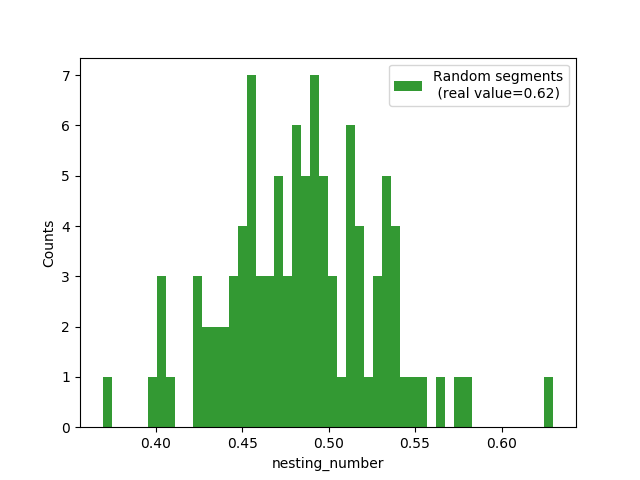

<IPython.core.display.Javascript object>


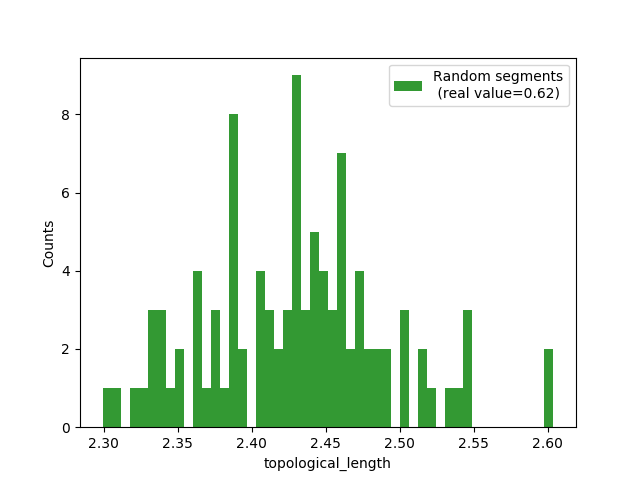

<IPython.core.display.Javascript object>


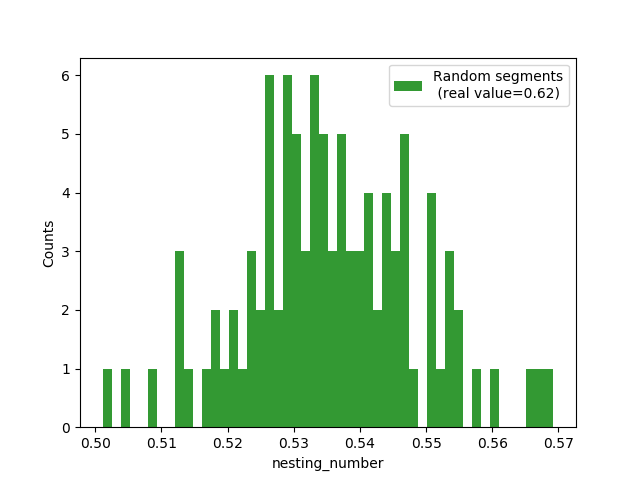

<IPython.core.display.Javascript object>


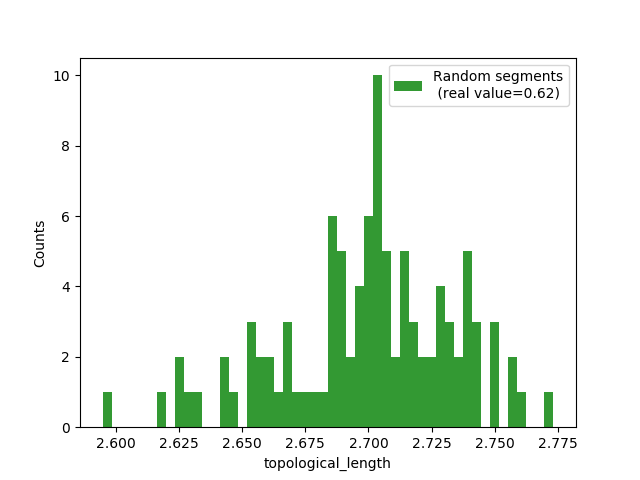

<IPython.core.display.Javascript object>


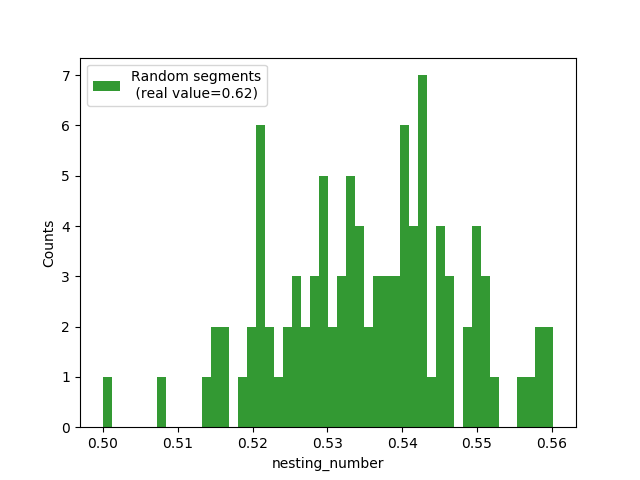

<IPython.core.display.Javascript object>


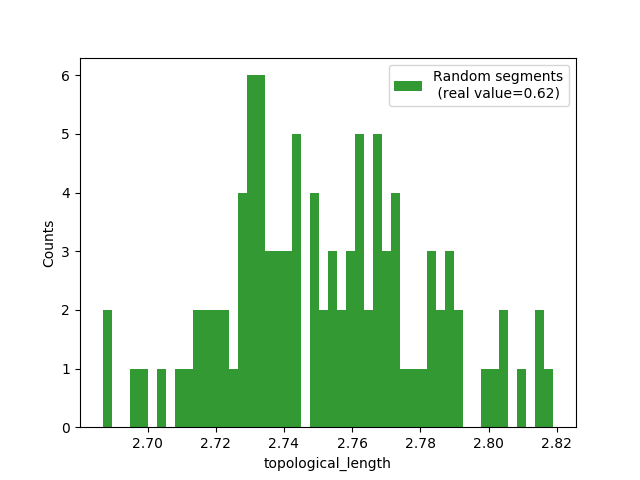

<IPython.core.display.Javascript object>


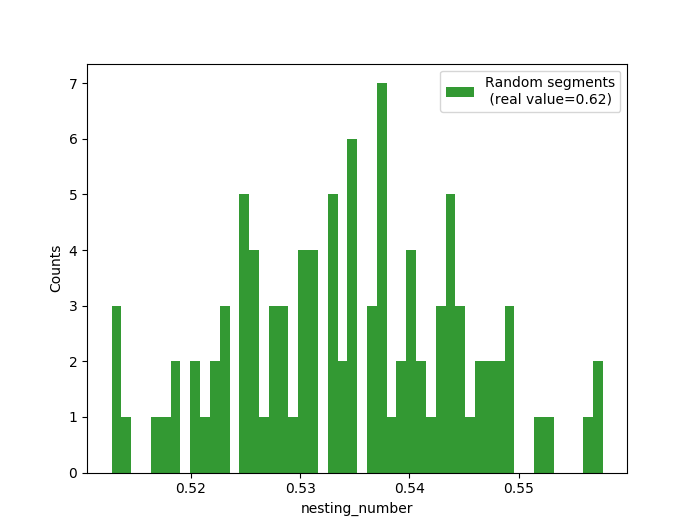

<IPython.core.display.Javascript object>


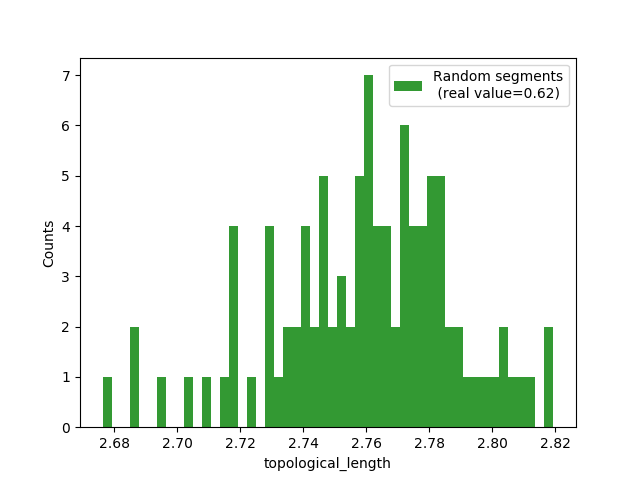

<IPython.core.display.Javascript object>


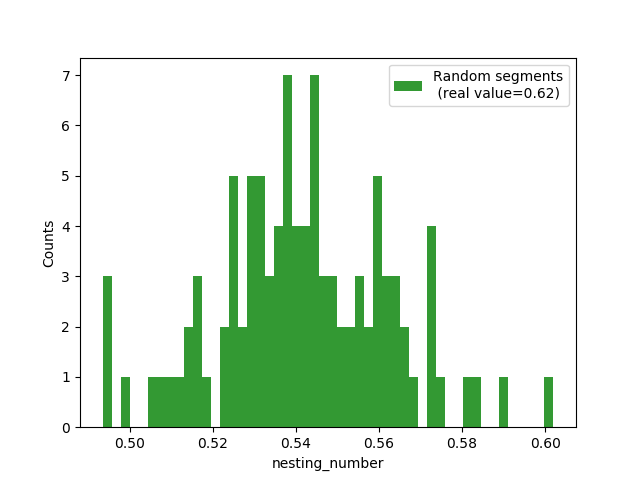

<IPython.core.display.Javascript object>


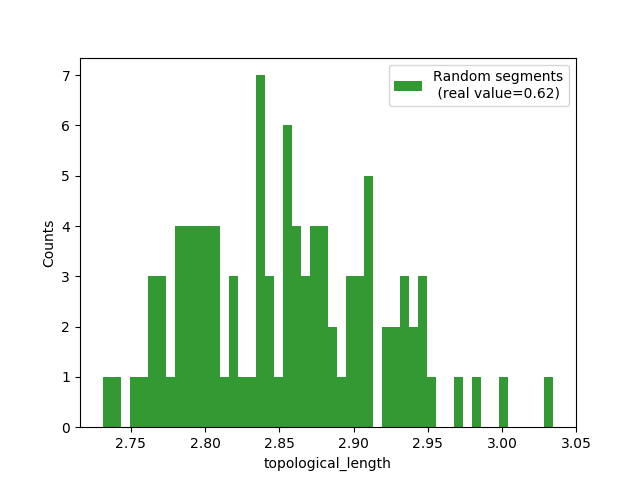

In [52]:
for network_id in network_ids:
    for feature_name in ['nesting_number', 'topological_length']:
        plt.figure()
        n, bins, patches = plt.hist(distributions[network_id][feature_name], 50, normed=0, facecolor='green', alpha=0.80, label='Random segments\n (real value=0.62)')
#n, bins, patches = plt.hist(distributions['BronxA_016']['topological_length'], 30, normed=0, facecolor='green', alpha=0.80)
        plt.xlabel(feature_name)
        plt.ylabel('Counts')
        plt.legend()